# Topic Modeling
Intention of this notebook is extraction (rather refinement) of *the topics* from *Complaint Type* and *Descriptor* textual data we have. We consider two settings:
* <a href="#supervized">supervized</a> (conditioned by the *query-term*) -- we want to capture the query-specific content
* <a href="#unsupervized">unsupervized</a> -- we want to create / update categorization

Note: we do not really have NLP context here -- the text is repetitive with some variations, the vocabulary is relatively limited, the standard NLP approach may or may not be the best way to go.

In [1]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
# get local configuration

with open('header','r') as source:
    FEATURES = source.read().strip().split(',')
    
with open('features-local','r') as source:
    features = source.read().strip().split(',')
    
YEARS = np.arange(2010, 2020)

#### 1. Extract vocabulary
Our [preprocessing](Preprocessing.ipynb#validate) removed some characters, however, some words may be irrelevant and should be removed as well. Let us see what the worst original values look like.

In [3]:
# textual features we are going to explore here
FEATURES.index('Complaint Type'), FEATURES.index('Descriptor')

(5, 6)

In [4]:
!tail -n20 ./data/dict-5.csv

(SELECT LOAD_FILE(\\\\615H,,,,,,,,,,1,1
(SELECT EXTRACTVALUE(XMLTYP,,,,,,,,,,1,1
() { _; } &GT;_,,,,,,,,,,1,1
() { :;}; /BIN/SLEEP 11,,,,,,,,,,1,1
() { :;}; /BIN/SLEEP 0,,,,,,,,,,1,1
&QUOT;--&GT;--&GT;`--&GT;&,,,,,,,,,,1,1
&LT;VLV XMLNS=&QUOT;HTTP://,,,,,,,,,,1,1
&LT;ODB XMLNS:XI=&QUOT;HTTP,,,,,,,,,,1,1
%{4761*8506},,,,,,,,,,1,1
%{(DM=@OGNLOGNLCONTEXT@DE,,,,,,,,,,1,1
%E5%98%8A%E5%98%8DX-INJECTI,,,,,,,,,,1,1
%C0%AE/WEB-INF/WEBXML,,,,,,,,,,1,1
%C0%AE/%C0%AE/WEB-INF/WEBXML,,,,,,,,,,1,1
%C0%AE/%C0%AE/%C0%AE/WEB-IN,,,,,,,,,,1,1
%C0%AE/%C0%AE/%C0%AE/%C0%AE,,,,,,,,,,1,1
%2FETC%2FPASSWD,,,,,,,,,,1,1
%2E%2E%5C%2E%2E%5C%2E%2E%5C,,,,,,,,,,1,1
%2E%2E%2F%2E%2E%2F%2E%2E%2F,,,,,,,,,,1,1
${3804*3137},,,,,,,,,,1,1
$(SLEEP 11),,,,,,,,,,1,10


Well... NYC-311 online requst submission form could use some love.

In [5]:
!tail -n20 ./data/dict-6.csv

DAMAGED/LEAKING ROOF,,,,,1,,,,,,1
CONTRACTOR RESPONSIBILITY/VENDEX,,,,,,,,,1,,1
CONSTRUCTION BEFORE/AFTER HOURS - FOR DEP INTERNAL USE ONLY,1,,,,,,,,,,1
CONCRETE WALLS,,,,,,,,,,1,1
COMMERCIAL RENT TAX- REFUND,,,,,,,,,1,,1
COMMERCIAL RENT TAX-,,,,,,,1,,,,1
CHILD CARE INFORMATION,,1,,,,,,,,,1
CHEMICAL ODOR,1,,,,,,,,,,1
CAPS & CHAINS MISSING-FIRE DEPT USE ONLY (WKMC),,,,,,,,,,1,1
CABLE TELEVISION,,,,,,,,1,,,1
BWSO REFERRAL TO WATER QUALITY (FOR DEP INTERNAL USE ONLY),1,,,,,,,,,,1
BUILDING INFORMATION/CONSTRUCTION HISTORY,,,,,,,,1,,,1
BIRTH/DEATH CERTIFICATES,,,,,,,,1,,,1
BECAUSE OF VIOLATION,,,,,,,,,1,,1
ASSAULT ON PARKS EMPLOYEE,,,1,,,,,,,,1
ALJ DIVISION,,,,,,,,1,,,1
ABANDONED,1,,,,,,,,,,1
A TENANTS GUIDE TO DRIE,,,1,,,,,,,,1
16 REQUEST CHANGES - ASP,,,,,,,,,,1,1
15X ICE-SNOW COND/PEDESTRN ACCESS,,,,,,,,,,1,10


Let us compile the stop-words list.

In [6]:
# use the same tokenizer we used for preprocessing
with open('./data/dict-5.csv','r') as source:
    junk = []
    for x in source.read().split('\n')[-150:]:
        junk += re.sub(r'[\W\d_]+',' ', x).strip().split()
junk = Counter(junk)
#count.most_common(100)

In [7]:
# after eyeballing the above
STOPWORDS = ' '.join([x for x in junk if junk[x] > 2])\
    +' ETC ECT PASSWD REQUEST QUOT FROM EVAL DEL BCC FORMPHP BIN XMLNS NONE'

We run this notebook iteratively to make adjustments based on previous result: here we make our addition to the stopwords.

In [8]:
# ignore words (yeah... MISCELLNOUS that very spelling)
STOPWORDS = set((STOPWORDS +' COMPLAINT COND CONDITION CONDITIONS MISCELLNOUS CATEGORIES GENERAL HAS ISSUE')\
                .lower().split() + stopwords.words('english'))

with open('./data/stop-words','w') as output:
    output.write(' '.join(list(STOPWORDS)))

Now we can work with main (preprocessed) files to extract relevant vocabulary.

In [9]:
# define our split (based on preprocessing we've done and observations from this notebook iterations)
def tokenize(x, ngrams = (1, 1), stem = lambda x:x):
    tokens = [stem(t) for t in x.split() if len(t) > 2 and t not in STOPWORDS]
    N = len(tokens)
    res = []
    for n in range(ngrams[0], ngrams[1] + 1):
        res += [' '.join(tokens[i:i+n]) for i in range(N - n + 1) ]
    return res

In [10]:
# use ngrams (min, max)
NGRAMS = (2, 2)
# use stemmer
STEM = PorterStemmer().stem

In [11]:
# process a single file in chunks
def get_vocabulary(y, chunk = 1000, ngrams = NGRAMS, stem = STEM):
    data = pd.read_csv('./data/{}.csv'.format(y), dtype = str)[['Complaint Type','Descriptor']].dropna()
    # use combined text from <Complaint Type> and <Descriptor>
    data = data.apply(lambda x: tokenize(x['Complaint Type'], ngrams = ngrams, stem = stem)\
                              + tokenize(x['Descriptor'], ngrams = ngrams, stem = stem), axis = 1)
    vocab = Counter(data.loc[:chunk].sum())
    for i in range(1, data.shape[0]//chunk + 1):
        start = i * chunk
        vocab += Counter(data.loc[start:start + chunk].sum())
    return vocab

In [12]:
# let's see one year
vocab = get_vocabulary(YEARS[0])
vocab.most_common(20)

[('nois residenti', 115013),
 ('loud music', 103570),
 ('music parti', 103473),
 ('paint plaster', 92840),
 ('water system', 70186),
 ('construct plumb', 53820),
 ('traffic signal', 53734),
 ('block drway', 49246),
 ('water leak', 44254),
 ('damag tree', 39181),
 ('dh advantag', 37852),
 ('derelict vehicl', 36135),
 ('illeg park', 33545),
 ('bang pound', 32857),
 ('dof properti', 31657),
 ('build use', 30654),
 ('miss collect', 27071),
 ('advantag tenant', 22474),
 ('nois commerci', 20831),
 ('residenti build', 20136)]

In [13]:
# corpus size
len(vocab)

1766

Next, we want to know how this result is different from year to year (we would expect some drift).

In [14]:
# initialize table to hold the data for all years
term_count = pd.DataFrame(list(vocab.items()), columns = ['term', YEARS[0]]).set_index('term')

In [15]:
# run the rest
for y in YEARS[1:]:
    print('Processing {}...'.format(y))
    vocab = get_vocabulary(y)
    count = pd.DataFrame(list(vocab.items()), columns = ['term', y]).set_index('term')
    term_count = term_count.reindex(term_count.index.union(count.index), fill_value = 0)
    term_count[y] = 0
    term_count.loc[list(vocab.keys()),y] = list(vocab.values())

Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
Processing 2019...


In [16]:
# let us see the most common terms
term_count['total'] = term_count.sum(axis = 1)
term_count = term_count.sort_values('total', ascending = False)
term_count.head(20).style.background_gradient(cmap = 'Oranges')

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
term,,,,,,,,,,,
loud music,103570,97839,115933,140201,183363,206727,219690,240479,226710,254072,1788584
music parti,103473,97743,115881,140181,183352,206720,219680,240463,226649,254058,1788200
nois residenti,115013,110232,126350,150159,191546,206527,215666,227601,214313,225125,1782532
heat hot,0,0,0,0,129613,222998,218468,196627,219695,204499,1191900
hot water,0,0,0,0,129613,222998,218468,196627,219695,204499,1191900
illeg park,33545,34037,31760,43783,62867,92004,119296,144983,161014,193544,916833
block drway,49246,52135,50294,56834,78602,100064,115278,134422,134932,133487,905294
entir build,0,0,0,0,85321,145382,143912,129042,141484,132726,777867
paint plaster,92840,100158,76942,78443,75136,69247,58894,56380,58844,33952,700836


In [17]:
term_count['total'].quantile([.25, .5, .75, 1.])

0.25         47.0
0.50        588.0
0.75       6450.0
1.00    1788584.0
Name: total, dtype: float64

In [18]:
# less common
term_count.tail(20).style.background_gradient(cmap = 'Oranges')

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
term,,,,,,,,,,,
respons inspect,0,0,0,0,0,1,0,0,0,0,1
manag licens,1,0,0,0,0,0,0,0,0,0,1
rem foreclosur,0,0,0,0,0,0,0,0,0,1,1
use zone,0,0,0,0,0,0,0,0,1,0,1
defect stlight,0,0,0,0,0,0,1,0,0,0,1
urdu full,0,0,0,0,1,0,0,0,0,0,1
miss fire,0,0,0,0,0,0,0,0,0,1,1
deliveri licens,0,0,0,0,0,0,0,0,1,0,1
chain miss,0,0,0,0,0,0,0,0,0,1,1


In [19]:
# changes in "terminology" ?
term_count[(term_count == 0).sum(axis = 1) > 0]

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
term,,,,,,,,,,,
heat hot,0,0,0,0,129613,222998,218468,196627,219695,204499,1191900
hot water,0,0,0,0,129613,222998,218468,196627,219695,204499,1191900
entir build,0,0,0,0,85321,145382,143912,129042,141484,132726,777867
bulki item,0,0,0,0,0,0,0,89984,355292,199266,644542
item collect,0,0,0,0,0,0,0,89984,355292,199266,644542
...,...,...,...,...,...,...,...,...,...,...,...
dept use,0,0,0,0,0,0,0,0,0,1,1
use wkmc,0,0,0,0,0,0,0,0,0,1,1
use wslt,0,0,1,0,0,0,0,0,0,0,1


In [20]:
# save vocabulary
term_count.to_csv('./data/vocabulary.csv')

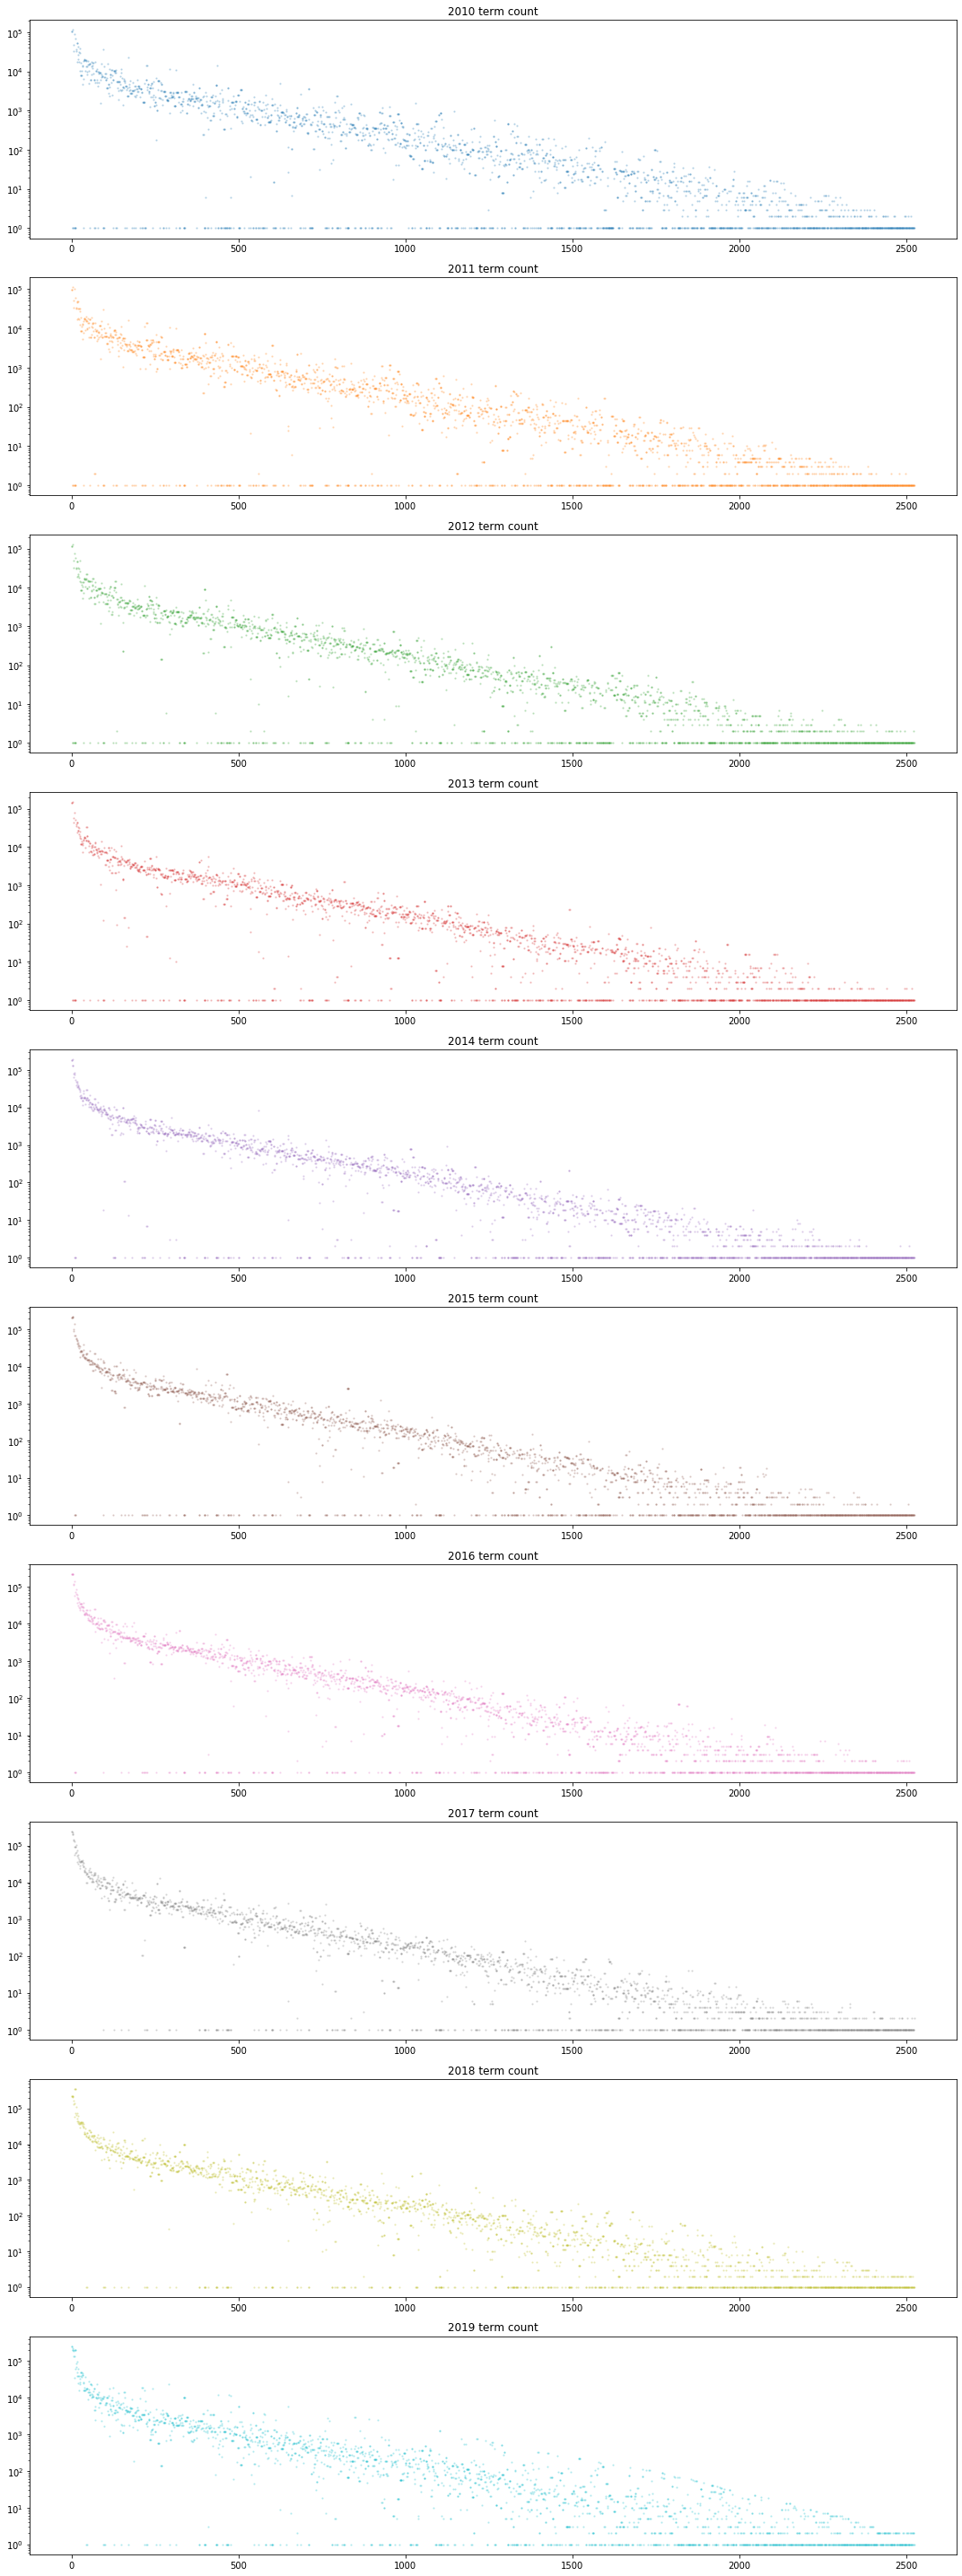

In [21]:
# vocabulary "profile" by year
fig, ax = plt.subplots(10, 1, figsize = (15, 40))
for i,y in enumerate(YEARS):
    ax[i].scatter(np.arange(len(term_count)), term_count[y].values + 1, s = 2, alpha = .2, color = 'C{}'.format(i))
    ax[i].set_title('{} term count'.format(y))
    ax[i].set_yscale('log')
plt.tight_layout()
plt.show()

<a name="supervized"></a>
#### Conditional query
For this experiment we take *Agency* feature and try to identify the most "relevant" words. (We also want to know if we can use *Agency* as proxi for the complaint type.)

Note: in general the query may be a single feature or multibple features, or any type of condition we can use to aggregate our data by.

In [22]:
topic_name = 'Agency'
topic = pd.read_csv('./data/index-{}.csv'.format(FEATURES.index(topic_name)))
# use only persistent topics (present in all years)
topic_index = [str(x + 1) for x in topic.dropna().index.tolist()]
topic = topic.dropna()['value'].tolist()

In [23]:
# use our compiled vocabulary
vocabulary = pd.read_csv('./data/vocabulary.csv')['term'].tolist()

In [24]:
# compile conditional vocabulary (topic-related)
def get_cond_vocab(y, topic_name, topic_index, chunk = 1000):
    data = pd.read_csv('./data/{}.csv'.format(y), dtype = str)\
            [[topic_name,'Complaint Type','Descriptor']].dropna()
    # take only values we care about
    data = data[data[topic_name].isin(topic_index)]
    # use combined text from <Complaint Type> and <Descriptor>
    data['tokens'] = data.apply(lambda x: tokenize(x['Complaint Type'], ngrams = NGRAMS, stem = STEM)\
                                        + tokenize(x['Descriptor'], ngrams = NGRAMS, stem = STEM), axis = 1)
    data = data[[topic_name,'tokens']]
    # make counter for each segment
    cond = pd.Series([Counter([]) for _ in range(len(topic_index))], index = topic_index)
    for i in range(data.shape[0]//chunk + 1):
        start = i * chunk
        add = data.iloc[start:start + chunk,:]\
                  .groupby(topic_name).sum()['tokens'].apply(lambda x:Counter(x))
        cond.loc[add.index] += add
    return cond

In [25]:
# let's see one year first
cond = get_cond_vocab(YEARS[0], topic_name, topic_index)
cond.head()

1    {'hpd literatur': 7720, 'mitchel lama': 868, '...
2    {'nois residenti': 115632, 'loud music': 10390...
3    {'traffic signal': 54168, 'veh signal': 4769, ...
4    {'improp dispos': 2296, 'plow spread': 6601, '...
5    {'hazard materi': 1983, 'hazmat problem': 95, ...
dtype: object

In [26]:
# initialize table to hold data for all years
cond_count = pd.DataFrame(np.zeros((len(vocabulary), len(topic))),
                          columns = topic,
                          index = vocabulary).astype(int)

In [27]:
# populate with the fist year data
for i,v in enumerate(topic_index):
    terms, label = cond.loc[v], topic[i]
    cond_count.loc[list(terms.keys()), label] = list(terms.values())
    print('\n{}:\n\t{}'.format(label, '\n\t'.join([str(x) for x in cond.loc[v].most_common(10)])))


HPD:
	('paint plaster', 93194)
	('water leak', 44463)
	('basin sink', 18515)
	('water suppli', 14295)
	('electr suppli', 11847)
	('electr wire', 11479)
	('electr ga', 8739)
	('ga rang', 8739)
	('hpd literatur', 7720)
	('ceram tile', 7032)

NYPD:
	('nois residenti', 115632)
	('loud music', 103901)
	('music parti', 103901)
	('block drway', 49972)
	('illeg park', 33948)
	('bang pound', 33091)
	('nois commerci', 20899)
	('nois sidewalk', 18111)
	('loud talk', 17924)
	('derelict vehicl', 14487)

DOT:
	('traffic signal', 54168)
	('fail repair', 15976)
	('muni meter', 13595)
	('broken muni', 13592)
	('light cycl', 9279)
	('defect hardwar', 7266)
	('base door', 5933)
	('park meter', 5773)
	('broken park', 5766)
	('rough pit', 5420)

DSNY:
	('miss collect', 27035)
	('derelict vehicl', 21698)
	('dump drop', 18327)
	('collect materi', 16309)
	('illeg poster', 10818)
	('litter basket', 8461)
	('dead anim', 8177)
	('plow spread', 6601)
	('dirti sidewalk', 6105)
	('dirti area', 6078)

DEP:
	('water

Looks like our choice of classification target does make sense after all.

In [28]:
cond_count.head(20).style.background_gradient(cmap = 'Reds', axis = 1)

,HPD,NYPD,DOT,DSNY,DEP,DOB,DPR,DOHMH,DOF,TLC,DCA,DHS,DFTA,DOE,EDC,NYCEM,DOITT
loud music,0,103901,0,0,98,0,0,0,0,0,0,0,0,0,0,0,0
music parti,0,103901,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nois residenti,0,115632,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
heat hot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
hot water,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
illeg park,0,33948,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
block drway,0,49972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
entir build,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
paint plaster,93194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bulki item,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# get the spectral-signature in the specified count quantile range
def show_dist(data, label, clip = [0, 1]):
    norm = data.values.sum()
    profile = data.sum(axis = 1).sort_values().values
    clip = (np.array(clip) * (len(profile) - 1)).astype(int)
    # clip to exclude most common and most rare
    matrix = (data[(data >= profile[clip[0]]) & (data <= profile[clip[1]])]).transpose() / norm
    
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    ax[0].set_yscale('log')
    ax[0].set_xticks([(profile > 0).sum()]) # count non-zero values
    ax[0].plot(profile[::-1])
    if clip[0] > 0: # lower count-bound
        ax[0].axhline(y = profile[clip[0]], color = 'C3', linestyle = ':')
    if clip[1] < len(profile) - 1: # upper count-bound
        ax[0].axhline(y = profile[clip[1]], color = 'maroon', linestyle = ':')
    ax[0].get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc:'{:,}'.format(int(x))))
    ax[0].set_title('{} term-counts distribution'.format(label))
    ax[1] = sbn.heatmap(matrix, xticklabels = False, cmap = 'Reds', cbar = False)
    
    ax[1].set_title('{} term-topic heatmap'.format(label))
    plt.show()

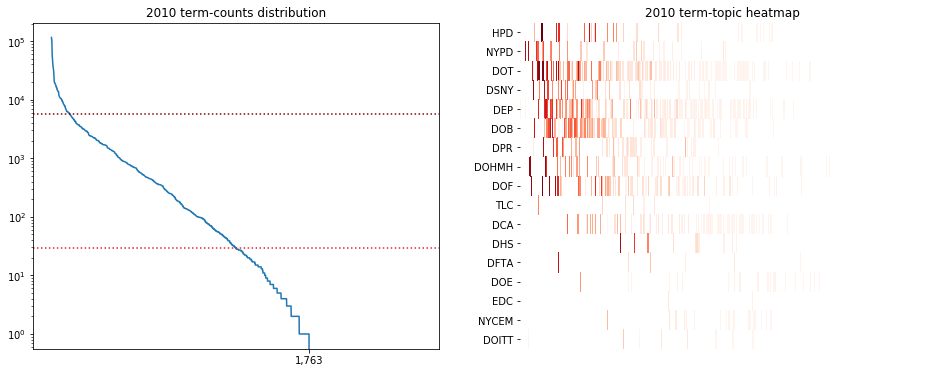

In [30]:
# see the terms with counts in the IQR
show_dist(cond_count, YEARS[0], clip = [0.5, 0.95])

In [ ]:
# run the same for the rest of YEARS
for y in YEARS[1:]:
    cond = get_cond_vocab(y, topic_name, topic_index)
    count = pd.DataFrame(np.zeros((len(vocabulary), len(topic))),
                         columns = topic,
                         index = vocabulary).astype(int)
    
    for i,v in enumerate(topic_index):
        terms, label = cond.loc[v], topic[i]
        count.loc[list(terms.keys()), label] = list(terms.values())
    
    show_dist(count, y, clip = [0.5, 0.95])
    cond_count += count

Observation: there is some similarity and some difference between the years.

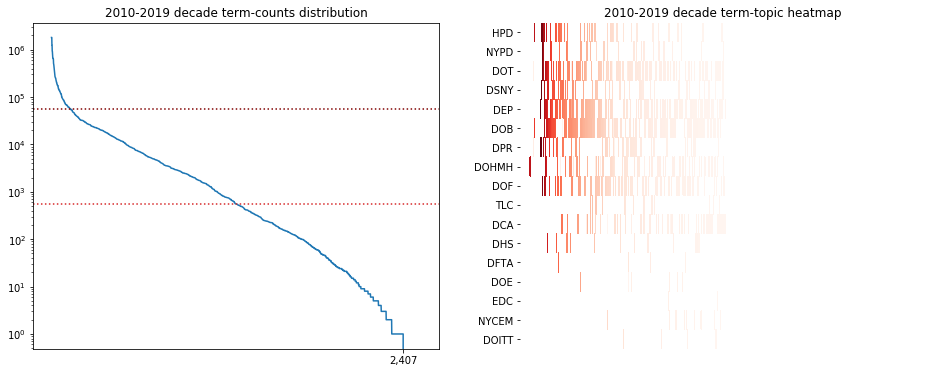

In [32]:
# check the merged
show_dist(cond_count, '{}-{} decade'.format(YEARS[0],YEARS[-1]), clip = [0.5, 0.95])

In [33]:
# get the most-selective tokens (high total in a single column) on the top
cond_count['total'] = cond_count[topic].sum(axis = 1)
cond_count['absent'] = (cond_count[topic] == 0).sum(axis = 1)
cond_count = cond_count[cond_count['total'] > 0].sort_values(['absent','total'], ascending = False)
cond_count.head(20)[topic].astype(int).style.background_gradient(cmap = 'Reds', axis = 1)

,HPD,NYPD,DOT,DSNY,DEP,DOB,DPR,DOHMH,DOF,TLC,DCA,DHS,DFTA,DOE,EDC,NYCEM,DOITT
heat hot,1235863,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
hot water,1235863,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
illeg park,0,930740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
block drway,0,921037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
entir build,805845,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
paint plaster,706594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bulki item,0,0,0,652670,0,0,0,0,0,0,0,0,0,0,0,0,0
item collect,0,0,0,652670,0,0,0,0,0,0,0,0,0,0,0,0,0
larg bulki,0,0,0,652670,0,0,0,0,0,0,0,0,0,0,0,0,0
water system,0,0,0,0,647896,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# check the less-selective tokens
cond_count.tail(20)[topic].astype(int).style.background_gradient(cmap = 'Reds', axis = 1)

,HPD,NYPD,DOT,DSNY,DEP,DOB,DPR,DOHMH,DOF,TLC,DCA,DHS,DFTA,DOE,EDC,NYCEM,DOITT
haitian creol,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,76,0
disrupt passeng,0,2,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ga leak,61,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
amus ride,0,0,0,0,0,4,0,0,0,0,32,0,0,0,0,0,0
light electr,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
loud music,0,1809329,0,0,387,0,0,0,0,0,0,0,0,0,0,0,2
nois sidewalk,0,473171,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
traffic signal,0,0,438623,0,0,1,0,1,0,0,0,0,0,0,0,0,0
loud talk,0,304349,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
dead anim,0,0,2482,82621,0,0,3240,0,0,0,0,0,0,0,0,0,0


In [35]:
# we have 17 values in the topic: 16 is the number we are looking for
exclusive = cond_count['absent'] == len(topic) - 1
cond_count['absent'].quantile([.25, .5, .75, 1.])

0.25    16.0
0.50    16.0
0.75    16.0
1.00    16.0
Name: absent, dtype: float64

In [36]:
# total count is also important: to validate the term it must be high enough
Q = cond_count['total'].quantile([.25, .5, .75, 1.])
Q

0.25         63.0
0.50        754.0
0.75       7070.0
1.00    1810083.0
Name: total, dtype: float64

In [37]:
# check "selectiveness" of the segment with sufficient count
cond_count.loc[cond_count['total'] > Q[.50], 'absent'].quantile([.25, .5, .75, 1.])

0.25    16.0
0.50    16.0
0.75    16.0
1.00    16.0
Name: absent, dtype: float64

In [38]:
Q = cond_count.loc[exclusive, 'total'].quantile([.25, .5, .75, 1.])
Q

0.25         57.0
0.50        635.0
0.75       5814.5
1.00    1235863.0
Name: total, dtype: float64

Looks like we can get near perfect separation here. We don't even need to train the model -- we can write it straigh down:

In [39]:
definitive = (exclusive) & (cond_count['total'] > Q[.5])
model = cond_count.loc[definitive, topic]
# binary representation (we have exclusive terms only)
(model > 0).astype(int)

,HPD,NYPD,DOT,DSNY,DEP,DOB,DPR,DOHMH,DOF,TLC,DCA,DHS,DFTA,DOE,EDC,NYCEM,DOITT
heat hot,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
hot water,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
illeg park,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
block drway,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
entir build,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
process server,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
miss defect,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
garag park,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
applic appeal,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [40]:
# number of terms per topic value in the model
(model > 0).sum(axis = 0).sort_values(ascending = False)

DOB      259
DEP      202
DOT      140
DOF      106
DOHMH     71
DSNY      70
HPD       62
DCA       61
DPR       57
NYPD      57
DHS       23
TLC       19
NYCEM     11
DOITT      5
DFTA       4
EDC        2
DOE        1
dtype: int64

<a name="agency"></a>

In [41]:
# see top terms in the model by topic value
for v in topic:
    print('\n{}:\n{}'.format(v, ', '.join(model[model[v] > 0].index.tolist()[:5])))


HPD:
heat hot, hot water, entir build, paint plaster, door window

NYPD:
illeg park, block drway, bang pound, nois commerci, sign violat

DOT:
muni meter, broken muni, coin card, card regist, sign damag

DSNY:
bulki item, item collect, larg bulki, miss collect, collect materi

DEP:
water system, nois construct, construct hour, hydrant run, backup use

DOB:
construct plumb, build use, residenti build, illeg convers, convers residenti

DPR:
tree branch, overgrown tree, limb fallen, branch limb, branch crack

DOHMH:
rat sight, food establish, attract rodent, mous sight, food poison

DOF:
dof properti, properti reduct, dof park, park payment, properti owner

TLC:
hire vehicl, drr passeng, drr report, non passeng, taxi report

DCA:
licens applic, new licens, dca doh, doh new, refund return

DHS:
dh advantag, advantag tenant, landlord broker, advantag landlord, payment receiv

DFTA:
hous option, assist live, home repair, nurs home

DOE:
heat problem

EDC:
nois helicopt, news gather

NYCEM:


Observation: bigrams appear to be all exclusive in this case.

In [42]:
# save results
model.astype(int).to_csv('./data/agency-terms.csv'.format(y))

<a name="unsupervized"></a>
#### Topic extraction
Now we want to find out if we can reduce the number of our complaint-type labels, however, the ultimate goal is to improve the overall caregorization, which may end up with the higher number of better labels.

In [43]:
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [44]:
# use our setting 
cv = CountVectorizer(tokenizer = lambda x:tokenize(x, ngrams = NGRAMS, stem = STEM), vocabulary = vocabulary)

In [45]:
# model
LDA()

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [46]:
# use summary to get a sample with proper distribution of counts
def make_sample(feature, norm = 1.):
    data = pd.read_csv('./data/dict-{}.csv'.format(FEATURES.index(feature))).fillna(0)
    data = data[data['total'] > len(YEARS)].sort_values('total', ascending = False)[['value','total']]
    total = data['total'].sum()
    data['total'] = (norm * data['total']).astype(int)
    return data.apply(lambda x: [x['value']] * x['total'], axis = 1).sum()

In [47]:
D = { d:cv.transform(make_sample(d, 0.001)) for d in ['Complaint Type','Descriptor'] }

for n in [5, 6, 7, 8, 17, 25]:
    print('Fitting {}...'.format(n))
    for f in ['Complaint Type','Descriptor']:
        print('⟨{}⟩'.format(f))
        lda = LDA(n_components = n, n_jobs = -1)
        _=lda.fit(D[f])
        for i,t in enumerate(lda.components_):
            print('\t#{}: {}'.format(i + 1, ', '.join([vocabulary[j] for j in t.argsort()[:-6:-1]])))
    print('\n')

Fitting 5...
⟨Complaint Type⟩
	#1: derelict vehicl, paint plaster, nois commerci, damag tree, muni meter
	#2: block drway, miss collect, homeless person, person assist, card replment
	#3: nois residenti, illeg park, traffic signal, mainten facil, dof park
	#4: larg bulki, bulki item, item collect, nois vehicl, water leak
	#5: water system, dof properti, properti reduct, properti owner, properti payment
⟨Descriptor⟩
	#1: block hydrant, derelict vehicl, illeg convers, convers residenti, hydrant run
	#2: partial access, rat sight, limb fallen, branch limb, miss collect
	#3: park sign, post park, sign violat, block sidewalk, sewer backup
	#4: bulki item, item collect, larg bulki, loud talk, build permit
	#5: entir build, licens plate, commerci overnight, overnight park, dirti sidewalk


Fitting 6...
⟨Complaint Type⟩
	#1: block drway, new tree, homeless person, person assist, mainten facil
	#2: larg bulki, item collect, bulki item, damag tree, miss collect
	#3: water leak, air qualiti, dh a

	#1: commerci overnight, overnight park, block traffic, doubl park, park block
	#2: dirti water, mous sight, overnight commerci, commerci storag, veh signal
	#3: block sidewalk, defect hardwar, block construct, cook ga, person sche
	#4: rat sight, miss recycl, waiv penalti, penalti late, late payment
	#5: sidewalk program, tree sidewalk, jack hammer, pothol hwi, cream truck
	#6: derelict vehicl, hydrant leak, year ago, plant year, litter basket
	#7: broken sidewalk, window frame, engin idl, address incorrect, bill address
	#8: attract rodent, coin card, card regist, branch tree, dead branch
	#9: crack rd, food stamp, secondari mean, egress door, altern servic
	#10: hydrant run, run full, sidewalk violat, slow leak, illeg poster
	#11: catch basin, tree fallen, entir tree, failur maintain, multipl light
	#12: water suppli, hydrant defect, payment receiv, receiv dh, chemic odor
	#13: copi statement, person star, star exempt, door frame, light lamp
	#14: partial access, fail repair, loud t

Observations: does not look very promising.

We may want to be able to label some subset of issues or a specific interest.

In [48]:
LABELS = 'noise heat light dirty leak rodent'.split()
source = 'Descriptor'

In [49]:
# use summary to get relevant vocabulary with terms weights
def get_relevant(feature, term, norm = .01):
    data = pd.read_csv('./data/dict-{}.csv'.format(FEATURES.index(feature)))[['value','total']]
    data['value'] = data['value'].apply(lambda x: re.sub(r'[\W\d_]+',' ', x).strip().lower())
    relevant = data['value'].str.contains(pat = term)
    if relevant.sum() == 0:
        return Counter([])
    # keep the same distribution
    terms = data.loc[relevant]\
                .apply(lambda x: tokenize(x['value'], ngrams = NGRAMS, stem = STEM) * int(norm * x['total']),
                       axis = 1)\
                .sum()
    return Counter(terms)

In [50]:
# check the first label
vocab = get_relevant(source, LABELS[0])
vocab.most_common(10)

[('nois construct', 2649),
 ('construct hour', 1998),
 ('nois bark', 687),
 ('bark dog', 687),
 ('construct equip', 651),
 ('nois air', 429),
 ('air ventil', 429),
 ('ventil equip', 429),
 ('nois jack', 324),
 ('jack hammer', 324)]

In [51]:
# initialize table to hold the data for all years
label_vocab = pd.DataFrame(list(vocab.items()), columns = ['term', LABELS[0]]).set_index('term')

# populate for all labels
for label in LABELS[1:]:
    vocab = get_relevant(source, label)
    count = pd.DataFrame(list(vocab.items()), columns = ['term', label]).set_index('term')
    label_vocab = label_vocab.reindex(label_vocab.index.union(count.index), fill_value = 0)
    label_vocab[label] = 0
    label_vocab.loc[list(vocab.keys()),label] = list(vocab.values())

In [52]:
label_vocab['absent'] = (label_vocab == 0).sum(axis = 1)
label_vocab['weight'] = label_vocab.sum(axis = 1)
label_vocab = label_vocab.sort_values(['absent','weight'], ascending = False)
label_vocab.head(20).style.background_gradient(cmap = 'Reds', axis = 0)

,noise,heat,light,dirty,leak,rodent,absent,weight
term,,,,,,,,
nois construct,2649,0,0,0,0,0,5,2654
construct hour,1998,0,0,0,0,0,5,2003
water leak,0,0,0,0,1695,0,5,1700
leak use,0,0,0,0,1269,0,5,1274
dirti sidewalk,0,0,0,973,0,0,5,978
dirti water,0,0,0,805,0,0,5,810
slow leak,0,0,0,0,758,0,5,763
bark dog,687,0,0,0,0,0,5,692
nois bark,687,0,0,0,0,0,5,692


In [53]:
label_vocab.tail(20).style.background_gradient(cmap = 'Reds', axis = 0)

,noise,heat,light,dirty,leak,rodent,absent,weight
term,,,,,,,,
overflow cko,0,0,0,0,4,0,5,9
rooftank leak,0,0,0,0,4,0,5,9
date time,3,0,0,0,0,0,5,8
dirti inadequ,0,0,0,3,0,0,5,8
equip facil,0,0,0,3,0,0,5,8
inadequ equip,0,0,0,3,0,0,5,8
loud music,3,0,0,0,0,0,5,8
mark date,3,0,0,0,0,0,5,8
music nighttim,3,0,0,0,0,0,5,8


In [54]:
label_vocab['absent'].quantile([.25, .5, .75, 1.])

0.25    5.0
0.50    5.0
0.75    5.0
1.00    5.0
Name: absent, dtype: float64

In [55]:
exclusive = label_vocab['absent'] == len(LABELS) - 1

Yet again, we have a nearly perfect separation.

In [56]:
Q = label_vocab['weight'].quantile([.25, .5, .75, 1.])
Q

0.25      22.0
0.50      65.0
0.75     209.0
1.00    2654.0
Name: weight, dtype: float64

In [57]:
definitive = (exclusive) & (label_vocab['weight'] > Q[.5])
label_vocab[definitive].style.background_gradient(cmap = 'Reds', axis = 0)

,noise,heat,light,dirty,leak,rodent,absent,weight
term,,,,,,,,
nois construct,2649,0,0,0,0,0,5,2654
construct hour,1998,0,0,0,0,0,5,2003
water leak,0,0,0,0,1695,0,5,1700
leak use,0,0,0,0,1269,0,5,1274
dirti sidewalk,0,0,0,973,0,0,5,978
dirti water,0,0,0,805,0,0,5,810
slow leak,0,0,0,0,758,0,5,763
bark dog,687,0,0,0,0,0,5,692
nois bark,687,0,0,0,0,0,5,692


In [58]:
# topic representation
label_vocab.loc[exclusive, LABELS].sum(axis = 0)

noise     11290
heat        359
light      1492
dirty      3004
leak       6050
rodent     1459
dtype: int64

In [59]:
# we might need to balance representation
weight = 1/label_vocab.loc[exclusive, LABELS].sum(axis = 0)
# take inverse and normalize to sum to 1
weight /= weight.sum()
weight

noise     0.018734
heat      0.589164
light     0.141763
dirty     0.070409
leak      0.034960
rodent    0.144969
dtype: float64

In [60]:
index = label_vocab[definitive].index
# fist column reserved for miss: label "other"
matrix = np.zeros((len(index), len(LABELS) + 1))
# the rest populate with counts
matrix[:,1:] = label_vocab.loc[definitive, LABELS].astype(float).values
# normalize
matrix[:,1:] /= matrix[:,1:].sum(axis = 0)
# weight
matrix[:,1:] *= np.tile(weight, (len(index), 1))

In [61]:
# save final
pd.DataFrame(matrix, columns = ['other'] + LABELS, index = index).to_csv('./data/label-terms.csv')

In [62]:
# use our label-terms
cv = CountVectorizer(tokenizer = lambda x:tokenize(x, ngrams = NGRAMS, stem = STEM), vocabulary = index.tolist())

In [63]:
# inference
def set_labels(y, feature, chunk = 1000, verbose = 5):
    data = pd.read_csv('./data/{}.csv'.format(y)).set_index('Unique Key')
    # get combined textual fields
    text = data[feature].fillna('')
    # initialize labels
    Y = np.zeros(data.shape[0])
    for i in range(1, data.shape[0]//chunk + 1):
        start = i * chunk
        X = cv.transform(text[start:start + chunk])
        Y[start:start + chunk] = X.dot(matrix).argmax(axis = 1)
    data[':local:'] = Y.astype(int)
    data.to_csv('./data/{}.csv'.format(y))
    if verbose:
        labeled = data.loc[data[':local:'] > 0, [':local:', feature]]
        print('\n\n{} {:.0%} labeled\n'.format(y, labeled.shape[0]/data.shape[0]))
        for i,v in enumerate(LABELS):
            print('{} [{}]:'.format(i + 1, v, labeled.shape[0]/data.shape[0]))
            print(labeled[labeled[':local:'] == i + 1].sample(n = verbose).to_string(index = False))

In [64]:
# check first year
set_labels(YEARS[0], source, verbose = 10)



2010 7% labeled

1 [noise]:
 :local:                                Descriptor
       1  noise construction before after hours nm
       1                   noise jack hammering nc
       1                      noise barking dog nr
       1            noise private carting noise nq
       1           noise construction equipment nc
       1  noise construction before after hours nm
       1                  noise ice cream truck nr
       1                      noise barking dog nr
       1            noise private carting noise nq
       1  noise construction before after hours nm
2 [heat]:
 :local:             Descriptor
       2  inadequate or no heat
       2  inadequate or no heat
       2             heat plant
       2             heat plant
       2             heat plant
       2             heat plant
       2             heat plant
       2             heat plant
       2             heat plant
       2             heat plant
3 [light]:
 :local:                Descriptor
 

In [ ]:
# do the rest
for y in YEARS[1:]: set_labels(y, source)

Observations: bigrams with stemming appear to be the most useful here (we cannot get away with a single word and a simple count threshold, for example: ice & snow issues labeled as noise because the ice-cream-truck managed to ennoy just everyone).

In [66]:
# create index based on the final settings
index = dict()

def proc(x): # our text preprocessing strategy
    return (' '.join(re.sub(r'[\W\d_]+',' ', x).strip().split())).lower()

for f in ['Complaint Type','Descriptor']:
    data = pd.read_csv('./data/dict-{}.csv'.format(FEATURES.index(f)))
    data['value'] = data['value'].apply(lambda x:(' '.join(tokenize(proc(x), ngrams = (1,1), stem = STEM))).strip())
    data = data[data['value'] != ''].groupby('value').sum().sort_values('total', ascending = False)
    index[f] = { x:i + 1 for i,x in enumerate(data.index.tolist()) }
    data.to_csv('./data/index-{}.csv'.format(FEATURES.index(f)))

In [67]:
# encode text-fields using new index
for y in YEARS:
    data = pd.read_csv('./data/{}.csv'.format(y)).set_index('Unique Key')
    for f in ['Complaint Type','Descriptor']:
        data[f] = data[f].fillna('').apply(lambda x:(' '.join(tokenize(x, ngrams = (1,1), stem = STEM))).strip())
        data[f] = data[f].apply(lambda x:index[f][x] if x in index[f] else '')
    data.to_csv('./data/{}.csv'.format(y))

In [ ]:
#!sed -i 's/\.0,/,/g' ./data/20*
#!sed -i 's/\.0,/,/g' ./data/index*